# Is there variance in Site Scanning and the Chrome User Experience Report (CrUX)?

Here, we look at the difference between CrUX data that reports the p75 values of the Core Web Vitals at the origin level and the results from the synthetic performance testing data from the Site Scanning report.

We learned during our interviews that most of the traffic on a site originates from search and not from the home page. Seeing what real users are experiencing at the origin-level may help illuminate other opportunities where performance was believed to be good based on the site scan but the real user data tells a different story.

In [53]:
"""
Loads result to dataframe and analyzes the results
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
from utils.load_results_to_dataframe import load_results_to_dataframe

notebook_dir = os.getcwd()

In [54]:
crux = load_results_to_dataframe(
    file_name="data/crux-data-202407.csv", notebook_dir=notebook_dir
)

sitescanning = load_results_to_dataframe(
    file_name="data/site-scanning-weekly-snapshot-20240722.csv",
    notebook_dir=notebook_dir,
)

sitescanning["final_url_website"] = "https://" + sitescanning["final_url_website"]

merged_df = pd.merge(sitescanning, crux, left_on="final_url_website", right_on="origin")
required_columns = [
    "origin",
    "p75_lcp",
    "largest_contentful_paint",
    "p75_cls",
    "cumulative_layout_shift",
    "p75_inp",
]
merged_df.drop_duplicates(subset="origin", keep="first", inplace=True)
merged_df = merged_df[required_columns].dropna()
merged_df.rename(
    columns={
        "p75_lcp": "lcp_crux_p75",
        "p75_cls": "cls_crux_p75",
        "largest_contentful_paint": "lcp_site_scanning",
        "cumulative_layout_shift": "cls_site_scanning",
    },
    inplace=True,
)
merged_df["lcp_difference_crux_vs_scan"] = (
    merged_df["lcp_crux_p75"] - merged_df["lcp_site_scanning"]
)
merged_df["cls_difference_crux_vs_scan"] = (
    merged_df["cls_crux_p75"] - merged_df["cls_site_scanning"]
)
merged_df["lcp_abs_difference_crux_vs_scan"] = abs(
    merged_df["lcp_crux_p75"] - merged_df["lcp_site_scanning"]
)
merged_df["cls_abs_difference_crux_vs_scan"] = abs(
    merged_df["cls_crux_p75"] - merged_df["cls_site_scanning"]
)

merged_df.sort_values(by="lcp_abs_difference_crux_vs_scan", ascending=False)

,origin,lcp_crux_p75,lcp_site_scanning,cls_crux_p75,cls_site_scanning,p75_inp,lcp_difference_crux_vs_scan,cls_difference_crux_vs_scan,lcp_abs_difference_crux_vs_scan,cls_abs_difference_crux_vs_scan
5417,https://apps.nea.gov,23800.0,107.100,0.0,0.000000,125.0,23692.900,0.000000,23692.900,0.000000
6817,https://invitation.nasa.gov,4200.0,26472.400,0.0,0.000045,75.0,-22272.400,-0.000045,22272.400,0.000045
1143,https://passport.intelink.gov,20500.0,1286.399,0.0,0.038292,25.0,19213.601,-0.038292,19213.601,0.038292
8470,https://crg.health.mil,5600.0,23345.399,0.0,0.000000,75.0,-17745.399,0.000000,17745.399,0.000000
2221,https://cce-datasharing.gsfc.nasa.gov,4600.0,21531.400,0.0,0.000000,50.0,-16931.400,0.000000,16931.400,0.000000
...,...,...,...,...,...,...,...,...,...,...
5062,https://mypaa.pbgc.gov,1400.0,1403.600,0.1,0.000609,25.0,-3.600,0.099391,3.600,0.099391
923,https://gravelocator.cem.va.gov,900.0,896.500,0.0,0.000000,75.0,3.500,0.000000,3.500,0.000000
1666,https://nyw.cap.gov,400.0,401.700,0.0,0.008690,50.0,-1.700,-0.008690,1.700,0.008690
2750,https://fhwaapps.fhwa.dot.gov,2700.0,2698.600,0.0,0.000000,25.0,1.400,0.000000,1.400,0.000000


## Data differences

A positive value for the mean or median difference in the below means that the values reported by the CrUX dataset were higher than the Site Scanning data, while a negative value for those columns indicates that the value reported by the Site Scanning data was higher.

In [55]:
data = {
    "Measure": ["LCP", "CLS"],
    "Mean Difference": [
        merged_df["lcp_difference_crux_vs_scan"].mean(),
        merged_df["cls_difference_crux_vs_scan"].mean(),
    ],
    "Median Difference": [
        merged_df["lcp_difference_crux_vs_scan"].median(),
        merged_df["cls_difference_crux_vs_scan"].median(),
    ],
    "Standard Deviation": [
        merged_df["lcp_difference_crux_vs_scan"].std(),
        merged_df["cls_difference_crux_vs_scan"].std(),
    ],
}

df = pd.DataFrame(data)
df.head()

,Measure,Mean Difference,Median Difference,Standard Deviation
0,LCP,1321.805917,1154.501000,1532.328846
1,CLS,-0.095793,-0.011766,0.278315


In [56]:
def draw_cwv_data_boxplot(metric_column, metric_label, **kwargs):
    """Makes a box plot"""
    plt.figure(figsize=(10, 6))
    bp = plt.boxplot(metric_column, vert=False)
    plt.title(f"{metric_label} Difference CrUX vs Site Scanning", fontsize=15)
    plt.xlabel(f"{metric_label} Difference CrUX vs Site Scanning", fontsize=12)

    for median in bp["medians"]:
        x, y = median.get_xydata()[1]  # top of the median line
        plt.text(x, y, f"{x:.3f}", horizontalalignment="center")  #

    if "file_name" in kwargs:
        plt.tight_layout()
        plt.savefig(
            kwargs["file_name"], dpi=(kwargs["dpi"] if "dpi" in kwargs else 300)
        )

    plt.show()

saving results to ./static/lcp-difference-crux-vs-scan.png


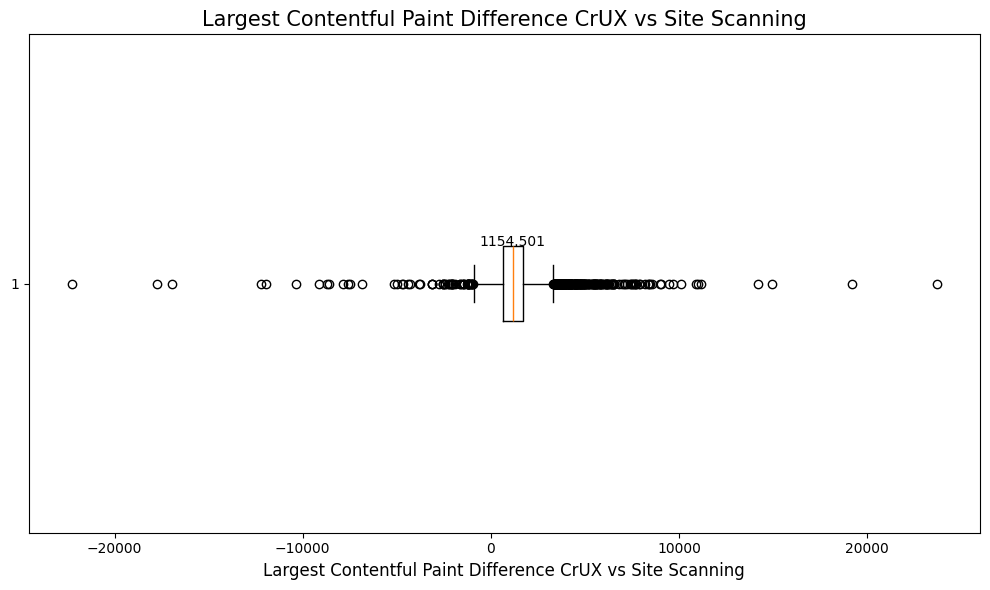

saving results to ./static/cls-difference-crux-vs-scan.png


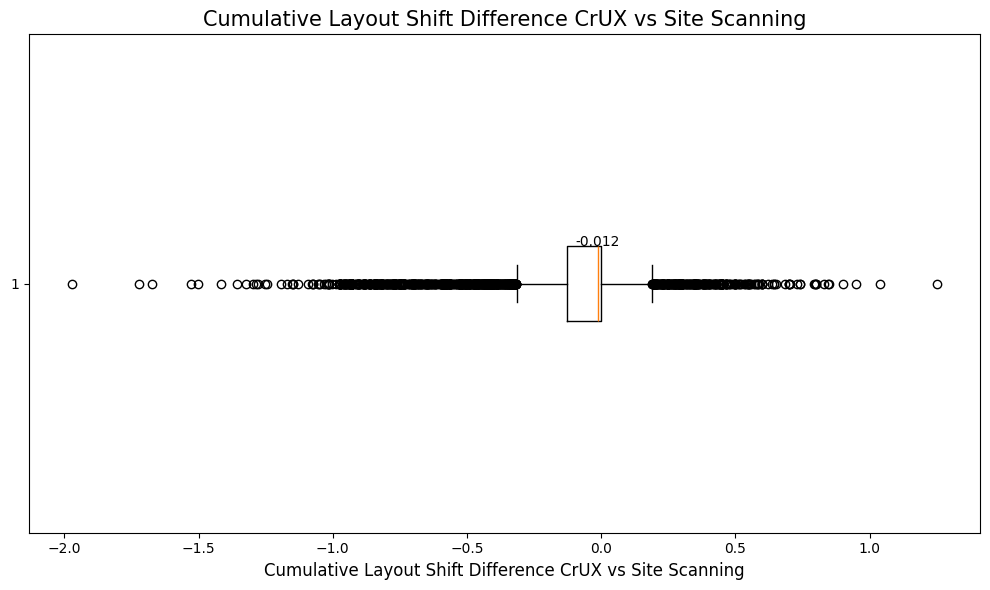

In [57]:
draw_cwv_data_boxplot(
    merged_df["lcp_difference_crux_vs_scan"],
    "Largest Contentful Paint",
    # file_name="./static/lcp-difference-crux-vs-scan.png"
)
draw_cwv_data_boxplot(
    merged_df["cls_difference_crux_vs_scan"],
    "Cumulative Layout Shift",
    # file_name="./static/cls-difference-crux-vs-scan.png"
)

## Good on Lab, not in field

Based on the differences in lab vs. field data, there are instances where the lab data indicates that the site is good but the field data tells another story.

In [58]:
field_lab_difference_lcp = merged_df[
    (merged_df["lcp_crux_p75"] > 2500) & (merged_df["lcp_site_scanning"] <= 2500)
]

field_lab_difference_cls = merged_df[
    (merged_df["cls_crux_p75"] > 0.1) & (merged_df["cls_site_scanning"] <= 0.1)
]

In [59]:
print(
    "There are "
    + str(merged_df.shape[0])
    + " rows with LCP and CLS columns in that appear in both the Site Scanning and CrUX reports."
)

print(
    "There are "
    + str(field_lab_difference_lcp.shape[0])
    + " rows where the lab value reports a good LCP but the field data tells a different story. "
    "This means there is a margin of error of "
    + str(field_lab_difference_lcp.shape[0] / merged_df.shape[0])
)

There are 4326 rows with LCP and CLS columns in that appear in both the Site Scanning and CrUX reports.
There are 918 rows where the lab value reports a good LCP but the field data tells a different story. This means there is a margin of error of 0.21220527045769763


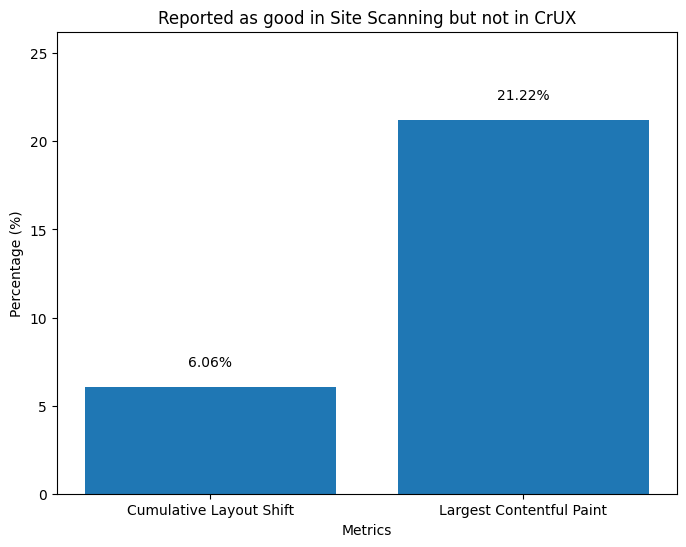

In [60]:
data = {
    "Cumulative Layout Shift": [len(field_lab_difference_cls)],
    "Largest Contentful Paint": [len(field_lab_difference_lcp)],
    "Total Rows": [len(merged_df)],
}

differences = pd.DataFrame(data)


cls_percentage = (field_lab_difference_cls.shape[0] / merged_df.shape[0]) * 100
lcp_percentage = (field_lab_difference_lcp.shape[0] / merged_df.shape[0]) * 100

# Visualization: Bar chart
fig, ax = plt.subplots(figsize=(8, 6))
percentages = [cls_percentage, lcp_percentage]
labels = ["Cumulative Layout Shift", "Largest Contentful Paint"]
ax.bar(labels, percentages)

# Add text labels for the bars
for i, v in enumerate(percentages):
    ax.text(i, v + 1, f"{v:.2f}%", ha="center", va="bottom")

ax.set_ylim(0, min(max(percentages) + 5, 100))
ax.set_title("Reported as good in Site Scanning but not in CrUX")
ax.set_ylabel("Percentage (%)")
ax.set_xlabel("Metrics")
plt.show()